In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
color_pal = sns.color_palette()


from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


## Import Data Files for Analysis

In [2]:
temperature_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_vic.csv")
temperature_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_qld.csv")
temperature_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/temperature_sa.csv")
forecastdemand_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_vic.csv")
forecastdemand_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_qld.csv")
forecastdemand_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/forecastdemand_sa.csv")
totaldemand_vic = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_vic.csv")
totaldemand_qld = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_qld.csv")
totaldemand_sa = pd.read_csv("C:/Users/aryan2/Assessment Data/totaldemand_sa.csv")


## Inspect and Clean Data

In [3]:
duplicates_exist = forecastdemand_sa.duplicated('DATETIME').any()

if duplicates_exist:
    print("Duplicate values exist in the 'DATETIME' column.")
else:
    print("No duplicate values found in the 'DATETIME' column.")

Duplicate values exist in the 'DATETIME' column.


In [4]:
# Identify and print duplicate rows
duplicate_rows = forecastdemand_sa[forecastdemand_sa.duplicated(subset='DATETIME', keep=False)]



print("Duplicate rows based on 'DATETIME' column:")
print(duplicate_rows)

# Remove duplicate values based on 'DATETIME' column
forecastdemand_sa = forecastdemand_sa.drop_duplicates(subset='DATETIME')

# Print the DataFrame after removing duplicates
print("\nDataFrame after removing duplicates:")
print(forecastdemand_sa)


Duplicate rows based on 'DATETIME' column:
         PREDISPATCHSEQNO REGIONID  PERIODID  FORECASTDEMAND  \
0              2016123018      SA1        71         1394.41   
1              2016123018      SA1        72         1285.07   
2              2016123018      SA1        73         1221.70   
3              2016123018      SA1        74         1141.86   
4              2016123018      SA1        75         1087.78   
...                   ...      ...       ...             ...   
4095587        2021031740      SA1        53         1228.07   
4095588        2021031740      SA1        54         1208.17   
4095589        2021031740      SA1        55         1199.27   
4095590        2021031740      SA1        56         1194.31   
4095591        2021031740      SA1        57         1190.41   

                 LASTCHANGED             DATETIME  
0        2016-12-30 12:31:25  2017-01-01 00:00:00  
1        2016-12-30 12:31:25  2017-01-01 00:30:00  
2        2016-12-30 12:31:25  20

In [18]:
temperature_sa

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
0,0,Adelaide (Kent Town),2010-01-01 00:00:00,23.6
1,1,Adelaide (Kent Town),2010-01-01 00:30:00,23.7
2,2,Adelaide (Kent Town),2010-01-01 01:00:00,23.5
3,3,Adelaide (Kent Town),2010-01-01 01:30:00,22.6
4,4,Adelaide (Kent Town),2010-01-01 02:00:00,22.0
...,...,...,...,...
208080,208080,Adelaide (Kent Town),2021-03-17 22:00:00,19.6
208081,208081,Adelaide (Kent Town),2021-03-17 22:30:00,19.5
208082,208082,Adelaide (Kent Town),2021-03-17 23:00:00,19.4
208083,208083,Adelaide (Kent Town),2021-03-17 23:30:00,19.6


In [5]:
temperature_vic.describe()

,TEMPERATURE
count,141681.000000
mean,15.711337
std,5.637641
min,0.800000
25%,11.800000
50%,14.900000
75%,18.700000
max,43.300000


In [7]:
temperature_sa['DATETIME'] = pd.to_datetime(temperature_sa['DATETIME'])

# Minimum and maximum dates
min_date = temperature_sa['DATETIME'].min()
max_date = temperature_sa['DATETIME'].max()

# Average time between each time sample
time_diff = temperature_sa['DATETIME'].diff().mean()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)
print("Average Time Between Samples:", time_diff)

Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between Samples: 0 days 00:28:19.898118067


In [9]:
# Convert 'DATETIME' column to datetime type if it's not already
totaldemand_sa['DATETIME'] = pd.to_datetime(totaldemand_sa['DATETIME'])

# Minimum and maximum dates
min_date = totaldemand_sa['DATETIME'].min()
max_date = totaldemand_sa['DATETIME'].max()

# Average time between each time sample
time_diff = totaldemand_sa['DATETIME'].diff().mean()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)
print("Average Time Between Samples:", time_diff)

Minimum Date: 2010-01-01 00:30:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between Samples: 0 days 00:30:00


In [8]:
# Convert 'DATETIME' column to datetime type if it's not already
forecastdemand_sa['DATETIME'] = pd.to_datetime(forecastdemand_sa['DATETIME'])

# Minimum and maximum dates
min_date = forecastdemand_sa['DATETIME'].min()
max_date = forecastdemand_sa['DATETIME'].max()

# Average time between each time sample
time_diff = forecastdemand_sa['DATETIME'].diff().mean()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)
print("Average Time Between Samples:", time_diff)

Minimum Date: 2017-01-01 00:00:00
Maximum Date: 2021-03-19 04:00:00
Average Time Between Samples: 0 days 00:30:00


## Explore Dataset - Plot a Month worth of Temperature Data

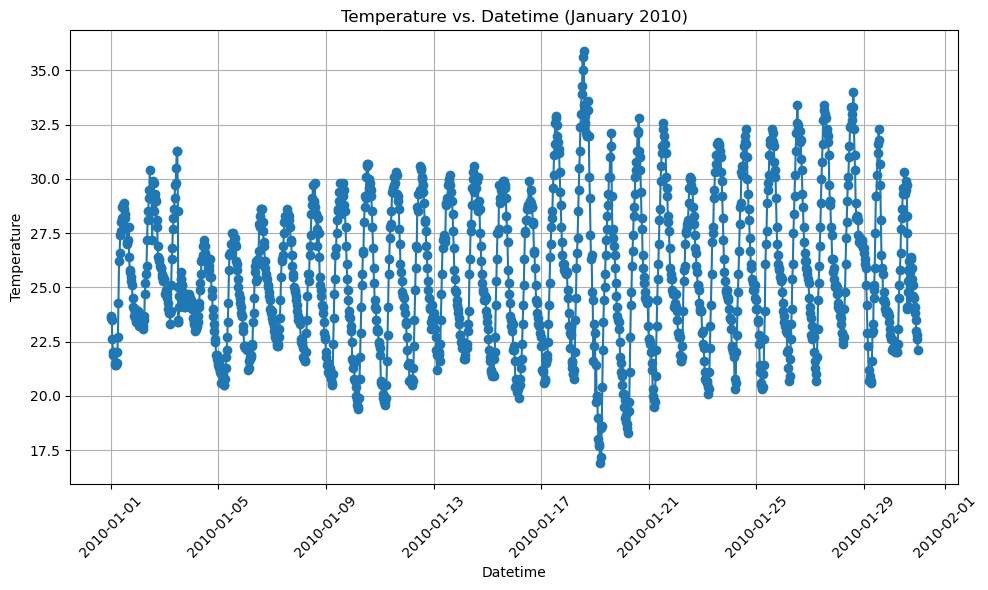

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming temperature_sa is your DataFrame

# Convert 'DATETIME' column to datetime type if it's not already
temperature_sa['DATETIME'] = pd.to_datetime(temperature_sa['DATETIME'])

# Filter data for a single month (for example, January 2024)
start_date = '2010-01-01'
end_date = '2010-01-31'
temperature_sa_single_month = temperature_sa[(temperature_sa['DATETIME'] >= start_date) & (temperature_sa['DATETIME'] <= end_date)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(temperature_sa_single_month['DATETIME'], temperature_sa_single_month['TEMPERATURE'], marker='o', linestyle='-')
plt.title('Temperature vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


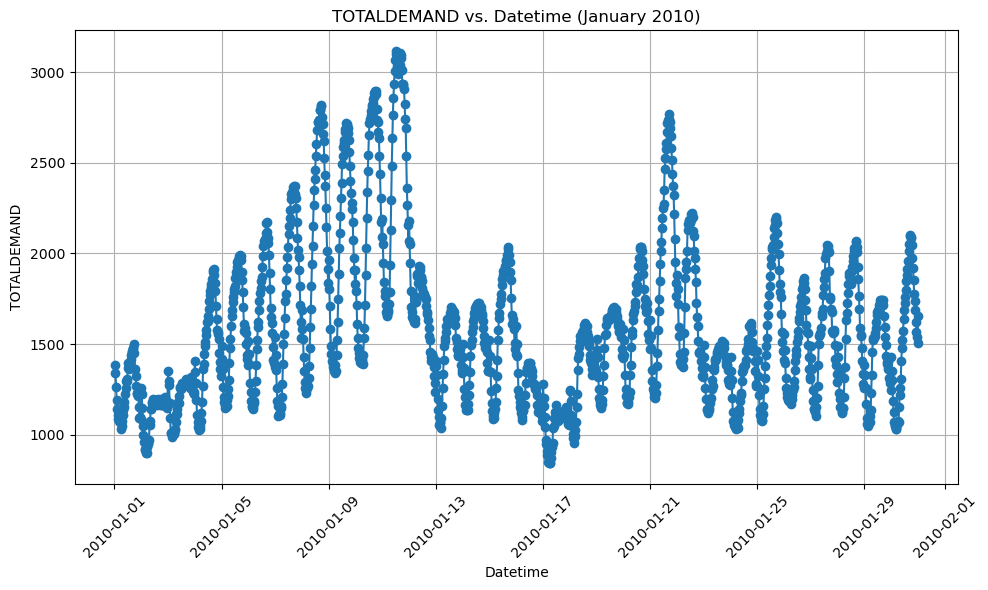

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming temperature_sa is your DataFrame

# Convert 'DATETIME' column to datetime type if it's not already
totaldemand_sa['DATETIME'] = pd.to_datetime(totaldemand_sa['DATETIME'])

# Filter data for a single month (for example, January 2024)
start_date = '2010-01-01'
end_date = '2010-01-31'
totaldemand_sa_single_month = totaldemand_sa[(totaldemand_sa['DATETIME'] >= start_date) & (totaldemand_sa['DATETIME'] <= end_date)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(totaldemand_sa_single_month['DATETIME'], totaldemand_sa_single_month['TOTALDEMAND'], marker='o', linestyle='-')
plt.title('TOTALDEMAND vs. Datetime (January 2010)')
plt.xlabel('Datetime')
plt.ylabel('TOTALDEMAND')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
sa_df = pd.merge(temperature_sa, totaldemand_sa, on='DATETIME', how='inner')

# Merge merged_df with forecastdemand_sa on 'DATETIME'
sa_df = pd.merge(sa_df, forecastdemand_sa, on='DATETIME', how='inner')

print(merged_df)

       Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0          128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1          128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2          128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3          128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4          128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   
...           ...                   ...                 ...          ...   
73736      208080  Adelaide (Kent Town) 2021-03-17 22:00:00         19.6   
73737      208081  Adelaide (Kent Town) 2021-03-17 22:30:00         19.5   
73738      208082  Adelaide (Kent Town) 2021-03-17 23:00:00         19.4   
73739      208083  Adelaide (Kent Town) 2021-03-17 23:30:00         19.6   
73740      208084  Adelaide (Kent Town) 2021-03-18 00:00:00         19.5   

       TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0          1469

In [31]:
temperature_sa['DATETIME'] = pd.to_datetime(temperature_sa['DATETIME'])

# Minimum and maximum dates
min_date = temperature_sa['DATETIME'].min()
max_date = temperature_sa['DATETIME'].max()

# Average time between each time sample
time_diff = temperature_sa['DATETIME'].diff().mean()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)
print("Average Time Between Samples:", time_diff)

Minimum Date: 2010-01-01 00:00:00
Maximum Date: 2021-03-18 00:00:00
Average Time Between Samples: 0 days 00:28:19.898118067


In [19]:
# Convert 'DATETIME' column to datetime type if it's not already
sa_df['DATETIME'] = pd.to_datetime(sa_df['DATETIME'])

# Find the index of the first date after the minimum date
start_index = sa_df.index[sa_df['DATETIME'] >= '2017-01-01 00:00:00'][0]

# Find the index of the last date before the maximum date
end_index = sa_df.index[sa_df['DATETIME'] <= '2021-03-18 00:00:00'][-1]

# Slice the DataFrame to keep only the values within the specified date range
sa_df = sa_df[start_index:end_index+1]

print(sa_df)

       Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0          128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1          128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2          128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3          128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4          128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   
...           ...                   ...                 ...          ...   
73736      208080  Adelaide (Kent Town) 2021-03-17 22:00:00         19.6   
73737      208081  Adelaide (Kent Town) 2021-03-17 22:30:00         19.5   
73738      208082  Adelaide (Kent Town) 2021-03-17 23:00:00         19.4   
73739      208083  Adelaide (Kent Town) 2021-03-17 23:30:00         19.6   
73740      208084  Adelaide (Kent Town) 2021-03-18 00:00:00         19.5   

       TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0          1469

In [20]:
column_names = sa_df.columns.tolist()
print(column_names)

['Unnamed: 0', 'LOCATION', 'DATETIME', 'TEMPERATURE', 'TOTALDEMAND', 'REGIONID_x', 'PREDISPATCHSEQNO', 'REGIONID_y', 'PERIODID', 'FORECASTDEMAND', 'LASTCHANGED']


In [32]:
# Check for null or missing values
null_values = sa_df.isnull().any()

# Print columns with missing values
print("Columns with missing values:")
print(null_values[null_values])

# Count total missing values
total_missing = sa_df.isnull().sum().sum()
print("Total missing values:", total_missing)


Columns with missing values:
Series([], dtype: bool)
Total missing values: 0


In [82]:
# Calculate the correlation between TEMPERATURE and TOTALDEMAND
correlation = sa_df['TEMPERATURE'].corr(sa_df['TOTALDEMAND'])

print("Correlation between TEMPERATURE and TOTALDEMAND:", correlation)


Correlation between TEMPERATURE and TOTALDEMAND: -0.20371041032086135


In [81]:
print(sa_df.describe())

          Unnamed: 0                       DATETIME   TEMPERATURE  \
count   73741.000000                          73741  73741.000000   
mean   168431.557695  2019-02-08 09:30:04.759902720     20.851593   
min    128958.000000            2017-01-01 00:00:00      1.500000   
25%    148521.000000            2018-01-20 06:00:00     17.000000   
50%    168479.000000            2019-02-08 10:00:00     21.400000   
75%    188242.000000            2020-02-27 14:30:00     24.900000   
max    208084.000000            2021-03-18 00:00:00     40.600000   
std     22860.811574                            NaN      5.747716   

       TOTALDEMAND  PREDISPATCHSEQNO      PERIODID  FORECASTDEMAND  \
count  73741.00000      7.374100e+04  73741.000000    73741.000000   
mean    1288.28930      2.018685e+09     55.504170     1282.207293   
min      284.51000      2.016123e+09     32.000000      194.630000   
25%     1086.79000      2.018012e+09     43.000000     1083.080000   
50%     1253.36000      2.01

## Check NEW DF for null or missing values

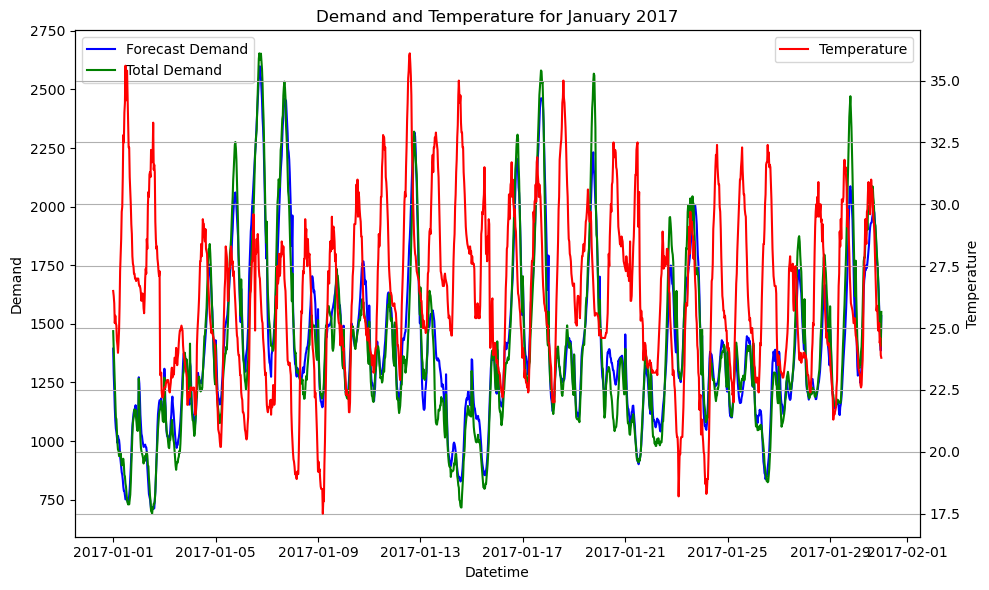

In [34]:
# Filter data for January 2017
january_2017_df = sa_df[(sa_df['DATETIME'] >= '2017-01-01') & (sa_df['DATETIME'] <= '2017-01-31')]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis (left)
ax1.plot(january_2017_df['DATETIME'], january_2017_df['FORECASTDEMAND'], label='Forecast Demand', color='blue')
ax1.plot(january_2017_df['DATETIME'], january_2017_df['TOTALDEMAND'], label='Total Demand', color='green')
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Demand', color='black')
ax1.tick_params('y', colors='black')
ax1.legend(loc='upper left')

# Secondary y-axis (right) for temperature
ax2 = ax1.twinx()
ax2.plot(january_2017_df['DATETIME'], january_2017_df['TEMPERATURE'], label='Temperature', color='red')
ax2.set_ylabel('Temperature', color='black')
ax2.tick_params('y', colors='black')
ax2.legend(loc='upper right')

plt.title('Demand and Temperature for January 2017')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Add in additional features

In [30]:
# Define a function to map months to seasons in Australia
def get_season_australia(month):
    if 1 <= month <= 2 or month == 12:
        return 'Summer'
    elif 3 <= month <= 5:
        return 'Autumn'
    elif 6 <= month <= 8:
        return 'Winter'
    else:
        return 'Spring'

# Extract month from DATETIME column
sa_df['MONTH'] = sa_df['DATETIME'].dt.month

# Map months to seasons for Australia
sa_df['SEASON'] = sa_df['MONTH'].apply(get_season_australia)

# Drop the intermediate 'MONTH' column if not needed
# sa_df.drop(columns=['MONTH'], inplace=True)


In [35]:
# Extract weekday from DATETIME column
sa_df['WEEKDAY'] = sa_df['DATETIME'].dt.weekday

# Print out a few rows to verify
print(sa_df.head())


   Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0      128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1      128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2      128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3      128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4      128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   

   TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0      1469.06        SA1        2016123018        SA1        71   
1      1395.21        SA1        2016123018        SA1        72   
2      1306.86        SA1        2016123018        SA1        73   
3      1239.58        SA1        2016123018        SA1        74   
4      1173.09        SA1        2016123018        SA1        75   

   FORECASTDEMAND          LASTCHANGED  YEAR  MONTH  DAY  HOUR  SEASON  \
0         1394.41  2016-12-30 12:31:25  2017      1    1     0  Summer   
1         

### Add in holidays

In [36]:
# pip install holidays

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for holidays from https://files.pythonhosted.org/packages/f0/64/6087fc1024f80fe30ca4188c82b8c533ea06f629632f78b8e45b4129df33/holidays-0.46-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.0 MB 656.4 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.0 MB 656.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.0 MB 1.3 MB/s eta 0:00:01
   ------------ --------------------------- 0.3/1.0 MB 1.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.4/1.0 MB 1.4 MB/s eta 0:00:01
   ---------------- ----------------------- 0.4/1.0 MB 1.5 MB/s eta 0:00:01
   ------------------------- -------------- 0.6/1.0 MB 1.8 MB/s eta 0:00:01
   ---------------------------- ----------- 0.7/

In [83]:
# Extract unique years from DATETIME column
years = sa_df['DATETIME'].dt.year.unique()

# Print out the years
print("Years contained in sa_df:", years)


Years contained in sa_df: [2017 2018 2019 2020 2021]


In [42]:
import pandas as pd
import holidays

# Generate Australian public holidays for a specific year
year = years  # Specify the year for which you want to generate public holidays
australian_holidays = holidays.AU(years=year)

# Convert the holidays to a DataFrame
holiday_dates = [(date, name) for date, name in australian_holidays.items()]
australian_public_holidays = pd.DataFrame(holiday_dates, columns=['Date', 'Holiday'])

# Print out the DataFrame
print(australian_public_holidays)


          Date         Holiday
0   2017-04-14     Good Friday
1   2017-04-17   Easter Monday
2   2017-01-01  New Year's Day
3   2017-01-26   Australia Day
4   2017-04-25       ANZAC Day
5   2017-12-25   Christmas Day
6   2017-12-26      Boxing Day
7   2018-03-30     Good Friday
8   2018-04-02   Easter Monday
9   2018-01-01  New Year's Day
10  2018-01-26   Australia Day
11  2018-04-25       ANZAC Day
12  2018-12-25   Christmas Day
13  2018-12-26      Boxing Day
14  2019-04-19     Good Friday
15  2019-04-22   Easter Monday
16  2019-01-01  New Year's Day
17  2019-01-26   Australia Day
18  2019-04-25       ANZAC Day
19  2019-12-25   Christmas Day
20  2019-12-26      Boxing Day
21  2020-04-10     Good Friday
22  2020-04-13   Easter Monday
23  2020-01-01  New Year's Day
24  2020-01-26   Australia Day
25  2020-04-25       ANZAC Day
26  2020-12-25   Christmas Day
27  2020-12-26      Boxing Day
28  2021-04-02     Good Friday
29  2021-04-05   Easter Monday
30  2021-01-01  New Year's Day
31  2021

In [51]:


# Convert 'Date' column to datetime type in australian_public_holidays DataFrame
australian_public_holidays['Date'] = pd.to_datetime(australian_public_holidays['Date'])

# Merge sa_df with australian_public_holidays based on the date
sa_df = pd.merge(sa_df, australian_public_holidays, left_on='DATETIME', right_on='Date', how='left')

# Create a new column indicating whether each date is a public holiday or not
sa_df['IS_PUBLIC_HOLIDAY'] = sa_df['Holiday'].notnull().astype(int)

# Drop the intermediate 'Date' and 'Holiday' columns if not needed
sa_df.drop(columns=['Date', 'Holiday'], inplace=True)

# Print out a few rows to verify
print(sa_df.head())



   Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0      128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1      128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2      128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3      128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4      128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   

   TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0      1469.06        SA1        2016123018        SA1        71   
1      1395.21        SA1        2016123018        SA1        72   
2      1306.86        SA1        2016123018        SA1        73   
3      1239.58        SA1        2016123018        SA1        74   
4      1173.09        SA1        2016123018        SA1        75   

   FORECASTDEMAND  ... MONTH  DAY  HOUR  SEASON  WEEKDAY     Date_x  \
0         1394.41  ...     1    1     0  Summer        6 2017-01-01   
1         1285.0

In [48]:
# Report column types
column_types = sa_df.dtypes

# Print out the column types
print("Column types in sa_df:")
print(column_types)


Column types in sa_df:
Unnamed: 0                    int64
LOCATION                     object
DATETIME             datetime64[ns]
TEMPERATURE                 float64
TOTALDEMAND                 float64
REGIONID_x                   object
PREDISPATCHSEQNO              int64
REGIONID_y                   object
PERIODID                      int64
FORECASTDEMAND              float64
LASTCHANGED                  object
YEAR                          int32
MONTH                         int32
DAY                           int32
HOUR                          int32
SEASON                       object
WEEKDAY                       int32
Date                 datetime64[ns]
Holiday                      object
IS_PUBLIC_HOLIDAY             int32
dtype: object


In [67]:
# Calculate Cooling and Heating values for sa_df
sa_df['Cooling'] = sa_df['TEMPERATURE'].apply(lambda x: max(0, x - 24))
sa_df['Heating'] = sa_df['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

# Print out a few rows to verify
print(sa_df[['Cooling', 'Heating']].head())

   Cooling  Heating
0      2.5      0.0
1      2.3      0.0
2      2.0      0.0
3      1.2      0.0
4      1.5      0.0


In [70]:
# Add a new column with an increasing index starting from 1
sa_df['INDEX'] = (sa_df['TEMPERATURE'].notnull()).cumsum().shift(fill_value=0) + 1

# Print out a few rows to verify
print(sa_df.head())

   Unnamed: 0              LOCATION            DATETIME  TEMPERATURE  \
0      128958  Adelaide (Kent Town) 2017-01-01 00:00:00         26.5   
1      128959  Adelaide (Kent Town) 2017-01-01 00:30:00         26.3   
2      128960  Adelaide (Kent Town) 2017-01-01 01:00:00         26.0   
3      128961  Adelaide (Kent Town) 2017-01-01 01:30:00         25.2   
4      128962  Adelaide (Kent Town) 2017-01-01 02:00:00         25.5   

   TOTALDEMAND REGIONID_x  PREDISPATCHSEQNO REGIONID_y  PERIODID  \
0      1469.06        SA1        2016123018        SA1        71   
1      1395.21        SA1        2016123018        SA1        72   
2      1306.86        SA1        2016123018        SA1        73   
3      1239.58        SA1        2016123018        SA1        74   
4      1173.09        SA1        2016123018        SA1        75   

   FORECASTDEMAND  ... WEEKDAY     Date_x       Holiday_x  IS_PUBLIC_HOLIDAY  \
0         1394.41  ...       6 2017-01-01  New Year's Day                  1  

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming sa_df is your DataFrame

# Define categorical, numerical, and binary features
categorical_features = ['WEEKDAY']
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'TEMPERATURE']
binary_features = ['IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating']

# Split features and target
X = sa_df[categorical_features + numerical_features + binary_features]
y = sa_df['TOTALDEMAND']

# Define preprocessing steps for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encode categorical features
        ('bin', 'passthrough', binary_features)  # Include binary features as is
    ])

# Create a pipeline with preprocessing and linear regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline (preprocessing + linear regression model) on training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)



Test MSE: 83951.17651125572
R^2 Score: 0.23722278089566617


In [79]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)


Epoch 1/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0126 - val_loss: 0.0108
Epoch 2/50
1844/1844 [==============================] - 2s 954us/step - loss: 0.0108 - val_loss: 0.0106
Epoch 3/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 4/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 5/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 6/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 7/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 8/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 9/50
1844/1844 [==============================] - 2s 1ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 10/50
1844/1844 [==============================] - 3s 2ms/step - loss: 0.0

# LSTM Model

In [60]:
# Define a mapping of seasons to integers
season_mapping = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}

# Map seasons to integers
sa_df['SEASON_INT'] = sa_df['SEASON'].map(season_mapping)

# Print out a few rows to verify
print(sa_df[['SEASON', 'SEASON_INT']].head())


   SEASON  SEASON_INT
0  Summer           1
1  Summer           1
2  Summer           1
3  Summer           1
4  Summer           1


In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# Extract relevant features from DATETIME column
sa_df['YEAR'] = sa_df['DATETIME'].dt.year
sa_df['MONTH'] = sa_df['DATETIME'].dt.month
sa_df['DAY'] = sa_df['DATETIME'].dt.day
sa_df['HOUR'] = sa_df['DATETIME'].dt.hour

# Select features and target
X = sa_df[['INDEX', 'TEMPERATURE', 'IS_PUBLIC_HOLIDAY', 'Cooling', 'Heating', 'WEEKDAY']].values
y = sa_df['FORECASTDEMAND'].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Define function to create time series dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define time steps
TIME_STEPS = 7

# Create time series dataset
X_ts, y_ts = create_dataset(X_scaled, y_scaled, TIME_STEPS)

# Split dataset into train and test sets
split = int(0.8 * len(X_ts))
X_train, X_test = X_ts[:split], X_ts[split:]
y_train, y_test = y_ts[:split], y_ts[split:]

# Define LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate model
mse = model.evaluate(X_test, y_test)
print("Test MSE:", mse)

# Make predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
print("Test RMSE:", rmse)


Epoch 1/50
1659/1659 [==============================] - 5s 2ms/step - loss: 0.0118 - val_loss: 0.0089
Epoch 2/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0079
Epoch 3/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 4/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 5/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 6/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 7/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 8/50
1659/1659 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 9/50
1659/1659 [==============================] - 4s 3ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 10/50
1659/1659 [==============================] - 4s 3ms/step - loss: 0.009

In [64]:
column_types = sa_df.dtypes

# Print out the column types
print("Column types in sa_df:")
print(column_types)

Column types in sa_df:
Unnamed: 0                    int64
LOCATION                     object
DATETIME             datetime64[ns]
TEMPERATURE                 float64
TOTALDEMAND                 float64
REGIONID_x                   object
PREDISPATCHSEQNO              int64
REGIONID_y                   object
PERIODID                      int64
FORECASTDEMAND              float64
LASTCHANGED                  object
YEAR                          int32
MONTH                         int32
DAY                           int32
HOUR                          int32
SEASON                       object
WEEKDAY                       int32
Date_x               datetime64[ns]
Holiday_x                    object
IS_PUBLIC_HOLIDAY             int32
Date_y               datetime64[ns]
Holiday_y                    object
Cooling                     float64
Heating                     float64
SEASON_INT                    int64
dtype: object


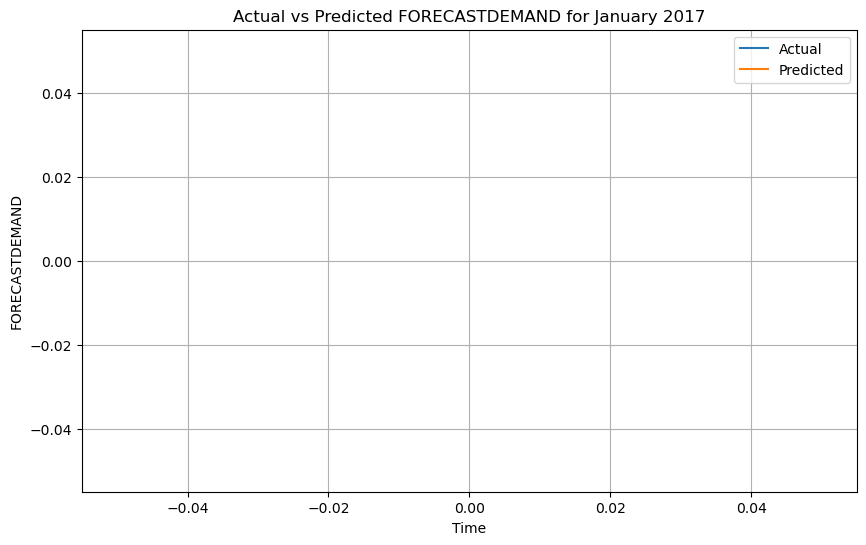

In [72]:

# Filter actual and predicted values for January 2017
january_2017_indices = np.where((X_test[:, :, 1] == 1) & (X_test[:, :, 0] == 2017))[0]

y_test_january_2017 = y_test[january_2017_indices]
y_pred_january_2017 = y_pred[january_2017_indices]

# Plot actual vs predicted values for January 2017
plt.figure(figsize=(10, 6))
plt.plot(y_test_january_2017, label='Actual')
plt.plot(y_pred_january_2017, label='Predicted')
plt.title('Actual vs Predicted FORECASTDEMAND for January 2017')
plt.xlabel('Time')
plt.ylabel('FORECASTDEMAND')
plt.legend()
plt.grid(True)
plt.show()
